In [1]:
from scipy.signal import find_peaks
import h5py as h5
from scipy.stats import norm
import numpy as np
import seaborn as sns
import probeinterface as pi
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from tqdm import tqdm
from matplotlib import pyplot as plt
import MEAutility as mu
import spikeinterface.full as si
import matplotx as mx
from sklearn.model_selection import train_test_split
from spikeinterface.sorters import WaveClusSorter
from tqdm import tqdm


def init_dataset_online(
    waveforms, raster, gt_raster, eval_size=0.2, test_size=0.2, batch_size=32
):

    # split dataset : train/eval/test
    wvs_rest, wvs_test, raster_rest, raster_test = train_test_split(
        waveforms, raster, test_size=test_size, shuffle=False
    )

    wvs_train, wvs_eval, raster_train, raster_eval = train_test_split(
        wvs_rest, raster_rest, test_size=eval_size / (1 - test_size), shuffle=False
    )

    gt_raster_train = gt_raster[:, gt_raster[0] < raster_eval[0]]

    gt_raster_eval = gt_raster[
        :, (gt_raster[0] >= raster_eval[0]) & (gt_raster[0] < raster_test[0])
    ]
    gt_raster_test = gt_raster[:, gt_raster[0] >= raster_test[0]]

    dataloaders = {
        "train": init_dataloader(wvs_train, raster_train, batch_size, normalize=False),
        "eval": init_dataloader(wvs_eval, raster_eval, batch_size, normalize=False),
        "test": init_dataloader(wvs_test, raster_test, batch_size, normalize=False),
    }

    dataset = {
        "train": {
            "wv": wvs_train,
            "raster": raster_train,
            "gt_raster": gt_raster_train,
        },
        "eval": {"wv": wvs_eval, "raster": raster_eval, "gt_raster": gt_raster_eval},
        "test": {"wv": wvs_test, "raster": raster_test, "gt_raster": gt_raster_test},
    }

    return dataset, dataloaders


def spike_detection_mads(mea_signal, mads, detection_th=5, win_width=40):
    """Detect peaks in the mea signal using 5*MAD method as threshold."""
    peaks_idx = []
    chan_peaks = []
    nchan = mea_signal.shape[0]
    for chan in range(nchan):
        y = mea_signal[chan, :]
        th = detection_th * mads[chan]
        one_chan_peaks, _ = find_peaks(-y, height=th, distance=win_width // 2)
        peaks_idx += list(one_chan_peaks)
        chan_peaks += [chan] * len(one_chan_peaks)
    peaks_idx, chan_peaks = np.asarray(peaks_idx), np.asarray(chan_peaks)
    perm = np.argsort(peaks_idx)
    return peaks_idx[perm], chan_peaks[perm], mads


def construct_waveform(
    signal,
    dt,
    win_width=40,
    detection_th=8,
    windowing="hanning",
    method="mads",
    mads=None,
    k_neo=3,
):
    "Segment the MEA recording signal in windows around detected peaks."
    ntime = signal.shape[1]
    t = np.arange(ntime) * dt
    # basic windowing duration = 4ms
    width0 = int(0.004 / dt) if win_width < int(0.004 / dt) else win_width
    if windowing == "hanning":
        padding = np.hanning(width0)
    else:
        padding = np.ones(width0)

    snippet_idx, chan_p, ths = spike_detection_mads(
        signal, mads, detection_th, win_width
    )

    ## Construct dataset
    snippets = []
    snippets_to_remove = []
    for p in tqdm(range(len(snippet_idx))):
        t_p = snippet_idx[p]  # peak index
        if (t_p + width0 // 2 < ntime) and (
            t_p - width0 // 2 > 0
        ):  # possible to construct a window around the peak
            s = signal[:, t_p - win_width // 2 : t_p + win_width // 2]
            # print("t_p is between ntime and 0")
            if (
                np.argmax(np.max(s, axis=1)) == chan_p[p]
            ):  # if the snippets is centered on the chan with max amplitude
                # padding can be apply now
                signal[:, t_p - width0 // 2 : t_p + width0 // 2] *= padding
                s = signal[:, t_p - win_width // 2 : t_p + win_width // 2]
                snippets.append(s.reshape(-1, 1))
            else:
                snippets_to_remove.append(p)
        else:
            snippets_to_remove.append(p)

    snippet_idx = np.delete(snippet_idx, snippets_to_remove)
    snippets = np.hstack(snippets)
    # mask = filter_collisions(snippet_units, col_rate) #TODO: add colision filter if necessary
    # snippets, snippet_units = snippets[:, mask], snippet_units[:, mask]
    # snippet_idx = snippet_idx[mask]
    return snippets, snippet_idx


# compute recall per neuron
def compute_recall(snippet_idx, gt_raster, snr):
    # compute recall for each neuron for neo and
    labels = np.zeros(len(snippet_idx))
    gt_st = gt_raster[0]
    for i, idx in enumerate(snippet_idx):
        idx = np.where(np.abs(gt_st - idx) < 10)[0]
        if idx.size > 0:
            labels[i] = gt_raster[1][idx[0]]

        else:
            labels[i] = -1

    # for each neuron, compute recall
    recall = np.zeros(len(np.unique(gt_raster[1])))
    for i_n in range(len(np.unique(gt_raster[1]))):
        idx = np.where(labels == i_n)[0]
        nb_true_spikes = np.sum(gt_raster[1] == i_n)
        tp = len(idx)
        fn = nb_true_spikes - tp
        recall[i_n] = tp / (tp + fn)
    perm = np.argsort(snr)
    recall = recall[perm]
    fp = np.sum(labels == -1)
    return labels, recall, fp

In [2]:
def sinc_interpolation_fft(x: np.ndarray, s: np.ndarray, u: np.ndarray) -> np.ndarray:
    """
    Fast Fourier Transform (FFT) based sinc or bandlimited interpolation.

    Args:
        x (np.ndarray): signal to be interpolated, can be 1D or 2D
        s (np.ndarray): time points of x (*s* for *samples*)
        u (np.ndarray): time points of y (*u* for *upsampled*)

    Returns:
        np.ndarray: interpolated signal at time points *u*
    """
    num_output = len(u)

    # Compute the FFT of the input signal
    X = np.fft.rfft(x)

    # Create a new array for the zero-padded frequency spectrum
    X_padded = np.zeros(num_output // 2 + 1, dtype=complex)

    # Copy the original frequency spectrum into the zero-padded array
    X_padded[: X.shape[0]] = X

    # Compute the inverse FFT of the zero-padded frequency spectrum
    x_interpolated = np.fft.irfft(X_padded, n=num_output)

    return x_interpolated * (num_output / len(s))

### Load real public dataset with ground-truth

In [3]:
datFile01 = (
    "data/hc1/_dat/d533101.dat"  # "data/hc1/_dat/d561104.dat"  # "data/hc1/d533101.dat"
)
nchannels = 8  # 6
fs = 10000
# fs_up = 20000  # upsample frequency

# Load data
recording = si.read_binary(
    file_paths=datFile01,
    sampling_frequency=fs,
    dtype="int16",
    num_channels=nchannels,
    gain_to_uV=1,
    offset_to_uV=0,
)

In [4]:
# compute total duration of recording
duration = recording.get_num_frames() / fs
print(f"Duration of recording: {duration} s")

Duration of recording: 240.0256 s


In [5]:
# filter data
rec_f = si.bandpass_filter(recording, freq_min=300, freq_max=3000, dtype="float32")
tmax = 240
rec_f = rec_f.time_slice(0, tmax)
intra = rec_f.channel_slice([5])  # d533101 : [5]
extra = rec_f.channel_slice([1, 2, 3, 4])  # d533101 : [1, 2, 3, 4]
# extra = si.common_reference(extra, reference="global", operator="median")
mads_chan = si.get_noise_levels(extra)
mads_chan

array([15.5347  , 15.356299, 15.113734, 17.080732], dtype=float32)

In [6]:
# %matplotlib widget
# si.plot_traces(rec_f, backend='ipywidgets')

In [7]:
probe = pi.generate_linear_probe(4)
probe.set_device_channel_indices(np.arange(4))
extra = extra.set_probe(probe)

probe = pi.generate_linear_probe(1)
probe.set_device_channel_indices(np.arange(1))
intra = intra.set_probe(probe)

dth : [254.45659]


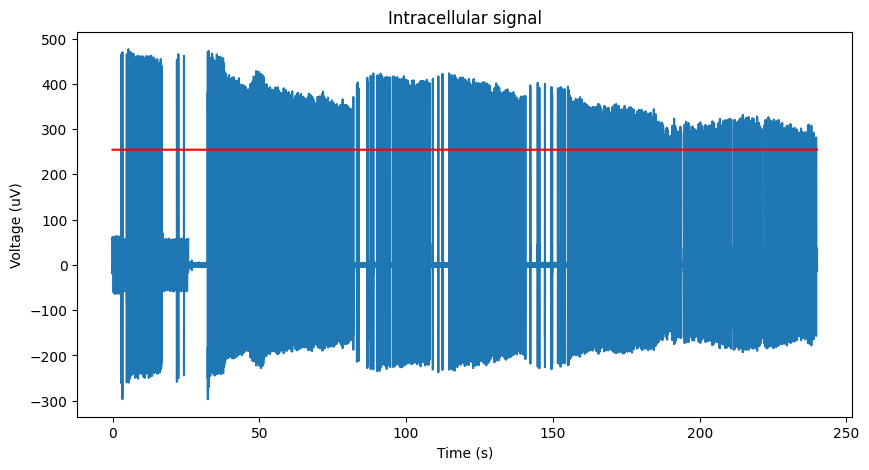

In [8]:
%matplotlib inline
factor = 200
dth = si.get_noise_levels(intra, return_scaled=False) * factor
print(f"dth : {dth}")
trace_intra = intra.get_traces()
trace_intra.shape[0] / fs
# plot the signal
trange = (0,int(tmax))
t = np.arange(trange[0]*fs, trange[1]*fs)/fs
plt.figure(figsize=(10, 5))
plt.plot(t,trace_intra[trange[0]*fs:trange[1]*fs])
# plot the threshold
plt.plot(t, dth*np.ones_like(t), 'r')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (uV)")
plt.title("Intracellular signal")
plt.show()

In [9]:
# detect ground-truth spikes
detection_th = factor
intra_peaks = detect_peaks(
    intra,
    method="locally_exclusive",
    detect_threshold=detection_th,
    peak_sign="pos",
    n_jobs=-1,
)
gt_st = intra_peaks["sample_index"].reshape(1, -1).astype(int)
print(f"number of detected peaks: {gt_st.shape[1]}")
gt_raster = np.vstack((gt_st, np.zeros(gt_st.shape[1], dtype=int)))

detect peaks using locally_exclusive:   0%|          | 0/240 [00:00<?, ?it/s]

number of detected peaks: 848


In [10]:
from spikeinterface.qualitymetrics import compute_quality_metrics

intra_sorting = si.NumpySorting.from_times_labels(
    [gt_raster[0]],
    [gt_raster[1]],
    fs,
)
job_kwargs = dict(n_jobs=-1, progress_bar=True)  # , chunk_duration="1s"
gt_analyzer = si.create_sorting_analyzer(intra_sorting, extra)
gt_analyzer.compute(
    ["random_spikes", "waveforms", "templates", "noise_levels"],
    **job_kwargs,
    verbose=False,
)
snr = compute_quality_metrics(
    gt_analyzer, metric_names=["snr"], n_jobs=-1
).values.squeeze()
snr

/home/alex/Simulations_WSL/_spikeinterface_3289/src/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


estimate_sparsity:   0%|          | 0/240 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/240 [00:00<?, ?it/s]

array(8.1545574)

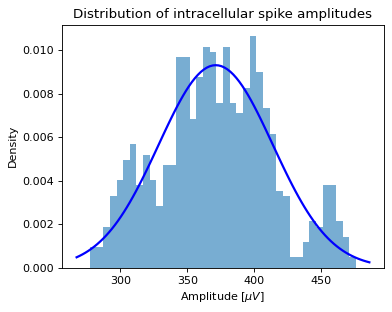

In [11]:
# plot intra-cellular spikes distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=80, tight_layout=True)
mean, std = norm.fit(intra_peaks["amplitude"])
ax.hist(intra_peaks["amplitude"], bins=40, density=True, alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
ax.plot(x, p, "b", linewidth=2)
ax.set_title("Distribution of intracellular spike amplitudes")
ax.set_xlabel("Amplitude [$\mu V$]")
ax.set_ylabel("Density")
plt.show()

In [12]:
detection_th = 5
delta_time = 2
extra_peaks = detect_peaks(
    extra,
    method="locally_exclusive",
    detect_threshold=detection_th,  # by default 5
    peak_sign="neg",
    n_jobs=-1,
)
peaks_idx = extra_peaks["sample_index"]
peaks_idx = peaks_idx[
    extra_peaks["amplitude"] > -1000
]  # remove peaks with amplitudes > 1000
peaks_idx = peaks_idx[
    (peaks_idx < int(109.5 * fs)) | (peaks_idx > int(110.5 * fs))
]  # remove peaks between 110 and 111s

# peaks_idx = np.delete(peaks_idx, np.where(np.diff(peaks_idx) < (3 * fs / 1000))[0])
peaks_idx_copy = peaks_idx.copy()
print(f"number of detected peaks: {len(peaks_idx)}")

tp = 0
fn = 0
not_detected_gt_spikes = []
well_detected_spikes = []
for i in range(gt_raster.shape[1]):
    idx = np.where(
        np.abs(peaks_idx_copy - gt_raster[0, i]) < delta_time * fs / 1000
    )  # search for a spike in a 1ms range
    if idx[0].size > 0:
        tp += 1
        well_detected_spikes.append(i)
        # idx_closest = np.argmin(np.abs(peaks_idx_copy - gt_raster[0, i]))
        # peaks_idx_copy = np.delete(peaks_idx_copy, idx_closest)
    else:
        fn += 1
        not_detected_gt_spikes.append(i)
precision = tp / gt_raster.shape[1]
recall = tp / (tp + fn)
print(f" true positives : {tp}")
print(f" false negatives : {fn}")
print(f" mean precision : {precision*100:.2f}%")
print(f" mean recall : {recall*100:.2f}%")

detect peaks using locally_exclusive:   0%|          | 0/240 [00:00<?, ?it/s]

number of detected peaks: 3516
 true positives : 845
 false negatives : 3
 mean precision : 99.65%
 mean recall : 99.65%


### Plots 

In [13]:
# # plot extra-cellular spikes distribution per channel
# from scipy.stats import norm

# fig, ax = plt.subplots(4, 1, figsize=(7, 5), dpi=80, sharex=True, tight_layout=True)
# for i in range(4):
#     # fit a normal distribution to the data
#     mean, std = norm.fit(extra_peaks["amplitude"][extra_peaks["channel_index"] == i])
#     # plot the histogram
#     ax[i].hist(
#         extra_peaks["amplitude"][extra_peaks["channel_index"] == i],
#         bins=40,
#         density=True,
#         alpha=0.6,
#     )
#     # plot the PDF
#     xmin, xmax = plt.xlim()
#     x = np.linspace(xmin, xmax, 100)
#     p = norm.pdf(x, mean, std)
#     # ax[i].plot(x, p, "b", linewidth=2)

# plt.show()

In [14]:
# # plot 4 extra-cellular channel and intra-cellular channel on a 5x1 subplot with detected spikes
# %matplotlib inline
# t_start = 10*fs #30500
# t_end = 240*fs #35000
# win_width = 60
# traces_extra = extra.get_traces(start_frame=t_start, end_frame=t_end).T
# traces_intra = intra.get_traces(start_frame=t_start, end_frame=t_end).T

# # get gt_raster in the selected time range
# selected_gt_spikes = gt_raster[:, (gt_raster[0] > t_start) & (gt_raster[0] < t_end)]
# gt_wvs = np.array(
#     [
#         intra.get_traces(
#             start_frame=idx - win_width // 2, end_frame=idx + win_width // 2
#         ).T
#         for idx in selected_gt_spikes[0]
#     ]
# ).squeeze()
# if len(gt_wvs.shape) == 1:
#     gt_wvs = gt_wvs.reshape(1, -1)

# # get extra-cellular waveforms in the selected time range
# selected_extra_spikes = np.where((peaks_idx > t_start) & (peaks_idx < t_end))[0]
# extra_wvs = np.array(
#     [
#         extra.get_traces(
#             start_frame=idx - win_width // 2, end_frame=idx + win_width // 2
#         ).T
#         for idx in peaks_idx[selected_extra_spikes]
#     ]
# ).squeeze()

# fig, ax = plt.subplots(5, 1, figsize=(10, 8), dpi=100, tight_layout=True, sharex=True)
# t = np.arange(t_start, t_end) / fs
# ax[0].set_title(f"Extra-cellular")
# for i in range(traces_extra.shape[0]):
#     ax[i].plot(t, traces_extra[i], color="black")
#     ax[i].text(0.9, 0.9, f"Chan #{i}", fontsize=12, transform=ax[i].transAxes)
#     ax[i].spines["top"].set_visible(False)
#     ax[i].spines["right"].set_visible(False)
#     ax[i].spines["bottom"].set_visible(False)
#     ax[i].set_xticks([])

# ax[4].plot(t, traces_intra[0], color="black")
# ax[4].set_title(f"Intra-cellular")
# ax[4].spines["top"].set_visible(False)
# ax[4].spines["right"].set_visible(False)
# ax[4].set_xlabel("Time [s]")

# # plot extra waveforms in green on all channels
# for i, extra_wv in enumerate(extra_wvs):
#     id_si = peaks_idx[selected_extra_spikes[i]]
#     t_wv = np.arange(id_si - win_width // 2, id_si + win_width // 2) / fs
#     # plot on extra axs
#     for chan in range(4):
#         ax[chan].plot(t_wv, extra_wv[chan], color="g", lw=1.1)
#     # plot on intra axs
#     ax[4].plot(
#         t_wv,
#         intra.get_traces(
#             start_frame=id_si - win_width // 2, end_frame=id_si + win_width // 2
#         ).T[0],
#         color="g",
#         lw=1.1,
#     )

# # plot gt waveforms in red on all channels
# for i, gt_wv in enumerate(gt_wvs):
#     id_si = selected_gt_spikes[0][i]
#     t_wv = np.arange(id_si - win_width // 2, id_si + win_width // 2) / fs
#     # plot on extra axs
#     for chan in range(4):
#         ax[chan].plot(
#             t_wv,
#             extra.get_traces(
#                 start_frame=id_si - win_width // 2, end_frame=id_si + win_width // 2
#             ).T[chan],
#             color="r",
#             ls="--",
#             lw=1.1,
#         )
#     # plot on intra axs
#     ax[4].plot(
#         t_wv,
#         gt_wv,
#         color="r",
#         lw=1.1,
#     )
# plt.show()

In [15]:
plt.close("all")

In [16]:
# %matplotlib widget
# si.plot_traces(
#     rec_f,
#     backend="ipywidgets",
#     mode="map",
#     order_channel_by_depth=True,
#     color="k",
#     channel_ids=[1, 2, 3, 4, 5],
# )

### Extract Extra-waveforms

In [17]:
## extract wvs around detected peaks
npeaks = peaks_idx.shape[0]
win_width = int(3 * fs / 1000)  # 3ms
nchan = extra.get_num_channels()
wvs = np.zeros((npeaks, nchan * win_width))

# upsample waveforms
ts = np.arange(0, win_width * nchan)
tu = np.arange(0, win_width * nchan, 0.5)
wvs_up = np.zeros((npeaks, nchan * win_width * 2))

peaks_to_remove = []
for i in tqdm(range(npeaks), desc="extracting waveforms"):
    if (peaks_idx[i] - int(win_width * 0.40)) > 0 and (
        peaks_idx[i] + int(win_width * 0.60)
    ) < extra.get_num_frames():
        wv = extra.get_traces(
            start_frame=peaks_idx[i] - int(win_width * 0.40),
            end_frame=peaks_idx[i] + int(win_width * 0.60),
        ).T.ravel()
        wv_up = sinc_interpolation_fft(wv, ts, tu)
        wvs[i] = wv
        wvs_up[i] = wv_up
    else:
        peaks_to_remove.append(i)

# remove peaks that are not extracted
wvs = np.delete(wvs, peaks_to_remove, axis=0)
peaks_idx = np.delete(peaks_idx, peaks_to_remove)
input_lca1_size = wvs.shape[1]

extracting waveforms: 100%|██████████| 3516/3516 [00:01<00:00, 1834.18it/s]


### Plot trace of 1 channel and gt waveform to see drift

In [18]:
from matplotlib.colors import LinearSegmentedColormap

## get trace
t_start = 0 * fs
t_end = extra.get_num_frames()
win_width = 30
traces_extra = extra.get_traces(start_frame=t_start, end_frame=t_end).T
traces_intra = intra.get_traces(start_frame=t_start, end_frame=t_end).T

# get gt_raster in the selected time range
selected_gt_spikes = gt_raster[:, (gt_raster[0] > t_start) & (gt_raster[0] < t_end)]
gt_wvs = np.array(
    [
        intra.get_traces(
            start_frame=idx - win_width // 2, end_frame=idx + win_width // 2
        ).T
        for idx in selected_gt_spikes[0]
    ]
).squeeze()
if len(gt_wvs.shape) == 1:
    gt_wvs = gt_wvs.reshape(1, -1)


## extract all gt_spikes and compute snr
extra_gt_spikes = np.zeros((len(gt_raster[0]), nchan * win_width))
padding = np.ones(win_width).reshape(1, -1)
for i, idx in enumerate(gt_raster[0]):
    etxra_gt_s = extra.get_traces(
        start_frame=idx - int(win_width * 0.40),
        end_frame=idx + int(win_width * 0.60),
    ).T
    extra_gt_spikes[i, :] = etxra_gt_s.flatten()
ngt_spikes = extra_gt_spikes.shape[0]

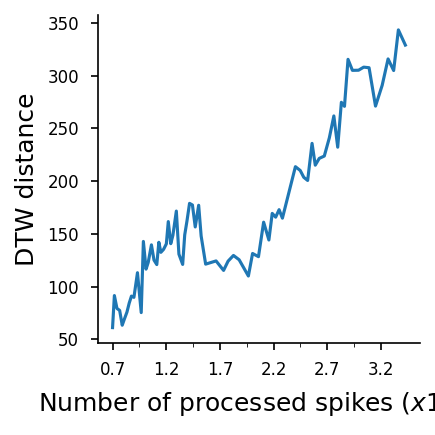

In [19]:
# DTW between the first 100 spikes and the rest of the spikes
import numpy as np

plt.style.use("seaborn-v0_8-paper")


def dtw_waveforms(x, y):
    n = len(x)
    m = len(y)

    # Initialize the cost matrix with high values
    D = np.zeros((n, m))
    D[0, 0] = (x[0] - y[0]) ** 2

    # Fill in the first row and first column
    for i in range(1, n):
        D[i, 0] = D[i - 1, 0] + (x[i] - y[0]) ** 2
    for j in range(1, m):
        D[0, j] = D[0, j - 1] + (x[0] - y[j]) ** 2

    # Fill in the rest of the matrix
    for i in range(1, n):
        for j in range(1, m):
            cost = (x[i] - y[j]) ** 2
            D[i, j] = cost + min(
                D[i - 1, j], D[i, j - 1], D[i - 1, j - 1]  # Insertion  # Deletion
            )  # Match

    # DTW distance is the square root of the bottom-right corner of D
    dtw_distance = np.sqrt(D[n - 1, m - 1])

    return dtw_distance, D


packet_size = 10
packet0 = 100
# Compute the DTW distance between the first 100 spikes and the rest of the spikes
dtw_distances = np.zeros((ngt_spikes - packet0) // packet_size)
spike_processed = np.zeros((ngt_spikes - packet0) // packet_size)
for i in range((ngt_spikes - packet0) // packet_size):
    dtw_distances[i], D = dtw_waveforms(
        np.mean(extra_gt_spikes[:packet0], axis=0),
        np.mean(
            extra_gt_spikes[
                i * packet_size + packet0 : (i + 1) * packet_size + packet0
            ],
            axis=0,
        ),
    )
    spike_processed[i] = np.sum(peaks_idx <= gt_raster[0][packet0 + i * packet_size])

# Plot the DTW distances
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.plot(spike_processed, dtw_distances, lw=1.5)
ax.set_xlabel("Number of processed spikes ($x10^{3}$)", fontsize=12)
ax.set_ylabel("DTW distance", fontsize=12)
# ax.tick_params(axis="both", labelsize=10)
ax.spines[["top", "right"]].set_visible(False)

ax.set_xticks(
    np.arange(
        spike_processed.min(),
        spike_processed.max() + 1,
        250,
    ),
    minor=True,
)
ax.set_xticks(
    np.arange(
        spike_processed.min(),
        spike_processed.max() + 1,
        500,
    )
)
ax.set_xticklabels(
    np.arange(
        spike_processed.min() * 1e-3,
        (spike_processed.max() + 1) * 1e-3,
        0.5,
    ).round(1),
)
plt.tight_layout()
plt.show()

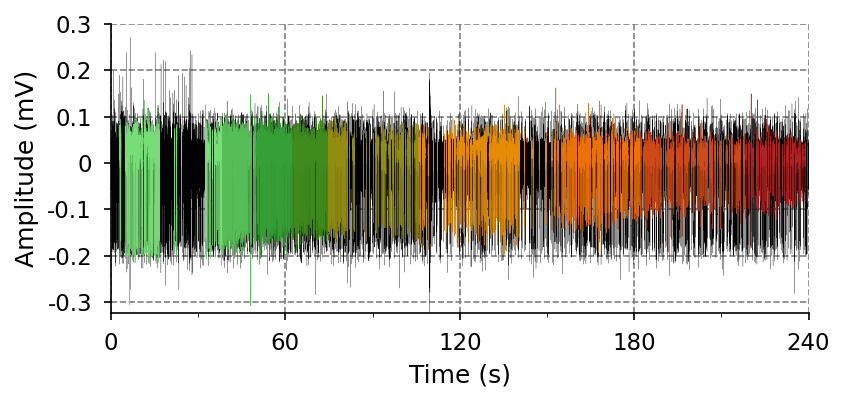

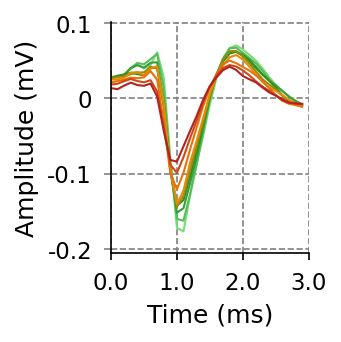

In [33]:
%matplotlib inline
scale = 1e-3
t = np.arange(t_start, t_end) / fs
chan = 1


### Init figure
# set space between subplots

plt.style.use("seaborn-v0_8-paper")
fig0, ax0 = plt.subplots(figsize=(6, 2.5), dpi=150)
fig1, ax1 = plt.subplots(figsize=(1.7, 2), dpi=150)
#set fontsize 

## Plot Trace and detected spikes
ax0.plot(t, traces_extra[chan]*scale, color="black", lw=0.1)
ax0.grid(True, linestyle="--", color="gray")
ax0.set_ylim([np.min(traces_extra[chan]*scale), np.max(traces_extra[chan]*scale)])
ax0.spines[["top", "right"]].set_visible(False)
ax0.set_xlim([0,240])
ax0.set_xticks(np.arange(0, 241, 30), minor=True)
ax0.set_xticks(np.arange(0, 241, 60))
ax0.set_xticklabels(np.arange(0, 241, 60), fontsize=11)
ax0.set_yticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
ax0.set_yticklabels(["-0.3", "-0.2", "-0.1", "0", "0.1", "0.2", "0.3"], fontsize=11)
ax0.set_xlabel("Time (s)", fontsize=12)
ax0.set_ylabel(f"Amplitude (mV)", fontsize=12)


# cm = sns.color_palette("viridis", gt_wvs.shape[0]+200)[:gt_wvs.shape[0]]
high_contrast_colors = ["#77DD77", "#228B22", "#FF8C00", "#B22222"]  # Dark green, dark orange, firebrick red
custom_cmap = LinearSegmentedColormap.from_list("_", high_contrast_colors)
packet_size = 100
cm = custom_cmap(np.linspace(0, 1, ngt_spikes // packet_size + 1))
color_idx = np.arange(0, ngt_spikes, packet_size)
t = np.arange(0, win_width)/fs* 1000 # to plot mean gt spikes
for i in range(ngt_spikes // packet_size+1):
    # plot gt spikes
    gt_id0, gt_id1  = i * packet_size, (i + 1) * packet_size if (i + 1) * packet_size < ngt_spikes else ngt_spikes
    for gti in range(gt_id0, gt_id1):
        id_si = selected_gt_spikes[0, gti]
        t_wv = np.arange(id_si - win_width // 2, id_si + win_width // 2) / fs
        ax0.plot(
            t_wv,
            extra.get_traces(
                start_frame=id_si - win_width // 2, end_frame=id_si + win_width // 2
            ).T[chan]*scale,
            color=cm[i],
            lw=0.2,
        )

    # compute mean gt_spike waveform by packet of 100 spikes to see the amplitude drift
    mean_gt_spikes = np.mean(
        extra_gt_spikes[i * packet_size : (i + 1) * packet_size, :], axis=0
    ).reshape(nchan, -1)
    ax1.plot(t, mean_gt_spikes[chan, :]*scale, color=cm[i], lw=1)
    ax1.spines[["top", "right"]].set_visible(False)
    ax1.set_ylim([-0.205, 0.102])
    ax1.set_xlim([0, 3])
    # ax1.set_xticks(np.arange(0, win_width+1, 5)/ fs * 1000, minor=True)
    ax1.set_xticks(np.arange(0, win_width+1, 10)/ fs * 1000)
    ax1.set_xticklabels(np.arange(0, win_width+1, 10)/ fs * 1000, fontsize=11)
    ax1.set_xlabel("Time (ms)", fontsize=12)
    ax1.set_ylabel(f"Amplitude (mV)", fontsize=12)
    ax1.set_yticks([-0.2, -0.1, 0, 0.1])
    ax1.set_yticklabels(["-0.2", "-0.1", "0", "0.1"], fontsize=11)
    ax1.grid(True, linestyle="--", color="gray")
    # set y-ticks alpha to 0.5
    ax1.yaxis.set_tick_params(color="gray")
    
plt.show()

#save ax0 and ax1 to svg
fig0.savefig("figures/fi6a_TR1_trace.svg", format="svg",dpi=150,bbox_inches="tight")
fig1.savefig("figures/fi6a_TR1_mean_gt_spikes.svg", format="svg",dpi=150,bbox_inches="tight")

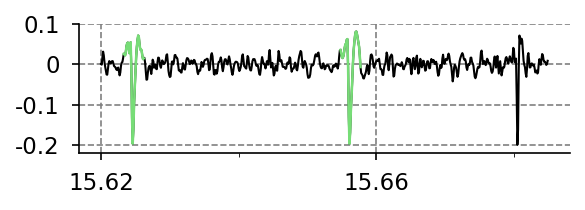

In [34]:
##plot zoom on a portion of the signal
t0, t1 = 15.62, 15.685
t = np.arange(t0 * fs, t1 * fs) / fs
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5), dpi=150, tight_layout=True)
ax.plot(t, traces_extra[chan][int(t0 * fs) : int(t1 * fs)] * scale, color="black", lw=1)
ax.grid(True, linestyle="--", color="gray")
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks(np.arange(t0, t1, 0.02), minor=True)
ax.set_xticks(np.arange(t0, t1, 0.04))
ax.set_xticklabels(np.arange(t0, t1, 0.04).round(2), fontsize=11)
ax.set_ylim([-0.22, 0.1])
ax.set_yticks([-0.2, -0.1, 0, 0.1])
ax.set_yticklabels(["-0.2", "-0.1", "0", "0.1"], fontsize=11)

# plot gt spikes on that portion with the corresponding color
cm = custom_cmap(np.linspace(0, 1, ngt_spikes // packet_size + 1))
color_idx = np.hstack(
    [[i] * packet_size for i in range(ngt_spikes // packet_size)]
    + [[ngt_spikes // packet_size + 1] * (ngt_spikes % packet_size)]
)
id_selected_gt_spikes = np.where((gt_raster[0] >= t0 * fs) & (gt_raster[0] <= t1 * fs))[
    0
]
for i, id_si in enumerate(
    gt_raster[0, (gt_raster[0] >= t0 * fs) & (gt_raster[0] <= t1 * fs)]
):
    t_wv = np.arange(id_si - win_width // 2, id_si + win_width // 2) / fs
    ax.plot(
        t_wv,
        extra.get_traces(
            start_frame=id_si - win_width // 2, end_frame=id_si + win_width // 2
        ).T[chan]
        * scale,
        color=cm[color_idx[id_selected_gt_spikes[i]]],
        lw=1.2,
    )
# save fig to svg
fig.savefig("figures/fi6a_drift_zoom_TR1.svg", format="svg")
plt.show()

### Try&Run NSS / PCA+KMeans / WaveClus3

In [ ]:
###Libraries parameters
## NSS
from model.Lca import LCA1iter, NSS_online
from utils.build_dataset import init_dataloader
from utils.metrics import GTSortingComparison

## PCA + KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Waveclus
import waveclus.pywaveclus.spike_detection as sd
import waveclus.pywaveclus.waveform_extraction as we
import waveclus.pywaveclus.feature_extraction as fe
import waveclus.pywaveclus.clustering as clu
import spikeinterface as si
from spikeinterface.preprocessing import filter

# init params
seed = 0
fs = 10000
ntrials = 2
nchan = 4
nneurons = 1
batch_size = 16
nPCs = 10

spike_packet = 100
tmax = 240
mask0 = peaks_idx < tmax * fs

# time_step = 30
# t0, tend = 0, tmax
# trange = (t0, tend)
# time_step = np.arange(trange[0], trange[1] + 1, time_step) * fs

# normalize waveforms with l2-norm
l2_norm = np.linalg.norm(wvs, ord=2, axis=1)
if np.sum(l2_norm < 1e-6) > 0:
    print("Warning: some waveforms are null")
wvs_n = wvs / np.linalg.norm(wvs, ord=2, axis=1)[:, None]
dataloaders = init_dataloader(
    wvs_n[mask0], peaks_idx[mask0], batch_size, normalize=False
)


def run_nss(dataloader, seed, N=8, model="TDQ", ths=[0.07, 0.07], n_atoms=[240, 10]):
    params_nss = {
        "n_atoms1": n_atoms[0],
        "n_atoms2": n_atoms[1],
        "D1_positive": False,
        "D2_positive": True,
        "th1": ths[0],
        "th2": ths[1],
        "fs": fs,
        "tau": 2e-3,
        "iters": 200,
        "lr": 0.07,
        "n_model": model,
        "q": 2**N - 1,
        "seed": seed,
    }
    params_nss["gamma"] = 1 / params_nss["fs"] / params_nss["tau"]

    ## init lca1
    lca1 = LCA1iter(
        input_size=next(iter(dataloader))[0].shape[1],
        gamma=params_nss["gamma"],
        threshold=params_nss["th1"],
        n_atoms=params_nss["n_atoms1"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D1_positive"],
        seed=params_nss["seed"],
    )
    lca2 = LCA1iter(
        input_size=params_nss["n_atoms1"],
        gamma=params_nss["gamma"],
        threshold=params_nss["th2"],
        n_atoms=params_nss["n_atoms2"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D2_positive"],
        seed=params_nss["seed"],
    )
    nss = NSS_online(lca1, lca2, params_nss["iters"], scale_factor=0.5)

    # training NSS
    nss_out = []
    n_spikes = []
    for _, (bi, ri) in enumerate(tqdm(dataloader)):
        if int(ri[-1]) / fs > 90:  # reduce lr after 120s
            nss.lca1.lr, nss.lca2.lr = 0.01, 0.01
            nss.iters = 100
            n_spikes.append(nss.lca1.n_spikes + nss.lca2.n_spikes)
        nss(bi)
        nss_out.append(nss.lca2.decoded_out.numpy())
    nss_out = np.concatenate(nss_out, axis=0)
    n_spikes = np.concatenate(n_spikes, axis=0)
    labels = np.argmax(nss_out, axis=1).astype(int)

    return labels, n_spikes

In [ ]:
## Run NSS
N_values = [1, 2, 4, 8]
nmodel = "TDQ"
for k, N in enumerate(N_values):
    print(f"Running NSS with N={N}")
    labels, nsp = run_nss(
        dataloaders, seed, N, model=nmodel, ths=[0.02, 0.02], n_atoms=[120, 10]
    )
    print(f"median nsp = {np.mean(nsp):.1f} +/- {np.std(nsp):.1f}")

    # compute fscore every packet of Ns spikes processed
    spike_processed, fscore_nss = [], []
    for i in range(0, len(peaks_idx), spike_packet):
        if i + spike_packet >= len(peaks_idx):
            break

        mask_pred = (peaks_idx >= peaks_idx[i]) & (
            peaks_idx < peaks_idx[i + spike_packet]
        )
        mask_gtr = (gt_raster[0] >= peaks_idx[i]) & (
            gt_raster[0] < peaks_idx[i + spike_packet]
        )
        gtsort_comp = GTSortingComparison(
            labels[mask_pred],
            peaks_idx[mask_pred],
            gt_raster[:, mask_gtr],
            fs,
            delta_time=1,
        )
        score = gtsort_comp.get_fscore()
        if not score.size > 0:
            continue
        else:
            spike_processed.append(i)
            fscore_nss.append(score)
    fscore_nss = np.array(fscore_nss).reshape(nneurons, -1)
    spike_processed = np.array(spike_processed)
    print(f"F1s NSS packet: {fscore_nss.mean()*100:.2f}%")

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(spike_processed, fscore_nss.T)
    plt.show()

In [ ]:
## PCA + KMeans
for t in range(ntrials):
    seed += t
    pcs = np.zeros((wvs_n.shape[0], nchan, nPCs))
    mask_train = peaks_idx < 90 * fs
    wvs_train = wvs_n[mask_train]
    wvs_eval = wvs_n[~mask_train]
    wvs_train = wvs_train.reshape(wvs_train.shape[0], nchan, -1)
    wvs_eval = wvs_eval.reshape(wvs_eval.shape[0], nchan, -1)
    for chi in range(nchan):
        pca = PCA(n_components=nPCs, random_state=seed, svd_solver="arpack")
        pcs[mask_train, chi] = pca.fit_transform(wvs_train[:, chi, :])
        pcs[~mask_train, chi] = pca.transform(wvs_eval[:, chi, :])

    pcs = pcs.reshape(-1, nchan * nPCs)
    kmeans = KMeans(n_clusters=3, init="random", random_state=seed, n_init=1).fit(pcs)
    labels = kmeans.labels_
    # compute fscore every packet of Ns spikes processed
    spike_processed, fscore_pcakm = [], []
    for i in range(0, len(peaks_idx), spike_packet):
        if i + spike_packet >= len(peaks_idx):
            break
        spike_processed.append(i)
        mask_pred = (peaks_idx >= peaks_idx[i]) & (
            peaks_idx < peaks_idx[i + spike_packet]
        )
        mask_gtr = (gt_raster[0] >= peaks_idx[i]) & (
            gt_raster[0] < peaks_idx[i + spike_packet]
        )
        gtsort_pcakm = GTSortingComparison(
            labels[mask_pred],
            peaks_idx[mask_pred],
            gt_raster[:, mask_gtr],
            fs,
            delta_time=1,
        )
        fscore_pcakm.append(gtsort_pcakm.get_fscore().round(4))
    fscore_pcakm = np.array(fscore_pcakm).T
    spike_processed = np.array(spike_processed)
    print(f"F1s PCAKM packet: {fscore_pcakm.mean()*100:.2f}%")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(time_step[1:] / fs, fscore_pk.T)
ax.plot(spike_processed, fscore_pcakm.T)
plt.show()

In [ ]:
# ## Waveclus
# # filter data
# rec_bp2 = filter(extra, band=[300, 3000], btype="bandpass", filter_order=2)
# rec_bp4 = filter(extra, band=[300, 3000], btype="bandpass", filter_order=4)

# # Step 1: Spike Detection
# detect_pks = sd.detect_spikes(extra, rec_bp2, rec_bp4)
# # Step 2: Feature Extraction
# wc_wvs = we.extract_waveforms(detect_pks, rec_bp2)

wc_wvs = {}
wvs_chan = wvs.reshape(wvs.shape[0], nchan, -1)
for ni in range(nchan):
    wc_wvs[ni] = wvs_chan[:, ni, :]

for t in range(ntrials):
    seed += 1
    features = fe.feature_extraction(wc_wvs, seed=seed)
    # Step 3: Clustering
    labels, metadata = clu.SPC_clustering(
        features, mintemp=0, maxtemp=0.251, swcycles=100, seed=seed
    )
    # compute fscore every packet of Ns spikes processed
    spike_processed, fscore_wc = [], []
    for i in range(0, len(peaks_idx), spike_packet):
        if i + spike_packet >= len(peaks_idx):
            break
        spike_processed.append(i)
        mask_pred = (peaks_idx >= peaks_idx[i]) & (
            peaks_idx < peaks_idx[i + spike_packet]
        )
        mask_gtr = (gt_raster[0] >= peaks_idx[i]) & (
            gt_raster[0] < peaks_idx[i + spike_packet]
        )
        for ci in range(nchan):
            label = labels[ci]
            gtsort_comp = GTSortingComparison(
                label[mask_pred],
                peaks_idx[mask_pred],
                gt_raster[:, mask_gtr],
                fs,
                delta_time=1,
            )
            fscore_wc.append(gtsort_comp.get_fscore().round(4))
    fscore_wc = np.array(fscore_wc).reshape(nchan, nneurons, -1)
    spike_processed = np.array(spike_processed)

    # fscore_wc = np.zeros((nchan, nneurons, time_step.size - 1))
    # for ci in range(nchan):
    #     # try:
    #     #     peaks_idx = detect_pks[ci]["indexes"]
    #     #     label = labels[ci]
    #     # except:
    #     #     peaks_idx = detect_pks[ci + 1]["indexes"]
    #     #     label = labels[ci + 1]
    #     label = labels[ci]
    #     gtr = gt_raster

    #     for i in range(1, time_step.size):
    #         mask = (peaks_idx >= time_step[i - 1]) & (peaks_idx < time_step[i])
    #         if np.sum(mask) == 0:
    #             continue
    #         else:
    #             labeli = label[mask]
    #             peaksi = peaks_idx[mask]
    #             gtri = gtr[:, (gtr[0] >= time_step[i - 1]) & (gtr[0] < time_step[i])]
    #             gtsort_comp_nss = GTSortingComparison(
    #                 labeli, peaksi, gtri, fs, delta_time=1
    #             )
    #             fscore_wc[ci, :, i - 1] = gtsort_comp_nss.get_fscore()

    # for each neuron determine the best channel
    best_chan = np.argmax(np.sum(fscore_wc, axis=2), axis=0)
    # fscore_wc_best = np.zeros((nneurons, time_step.size - 1))
    fscore_wc_best = np.zeros((nneurons, len(spike_processed)))
    # fill fscore_wc_best with the best channel from fscore_wc
    for ni in range(nneurons):
        fscore_wc_best[ni] = fscore_wc[best_chan[ni], ni]
    # print(f"mean F1s : {np.mean(fscore_wc_best[:,time_step[1:]>=90*fs])*100:.3f} %")
    print(f"F1s Waveclus packet: {fscore_wc_best.mean()*100:.2f}%")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(time_step[1:] / fs, fscore_wc_best.T)
ax.plot(spike_processed, fscore_wc_best.T)
plt.show()

### Save wvs

In [ ]:
# save static_rec, drift_rec and sorting to h5py file
with h5.File("./data/hc1/hc1_d533101_dth5_tmax240_noburst.h5", "w") as f:
    f.create_dataset("wvs", data=wvs)
    # f.create_dataset("wvs_up", data=wvs_up)  # wvs upsampled
    f.create_dataset("peaks_idx", data=peaks_idx)
    f.create_dataset("gt_raster", data=gt_raster)
    f.create_dataset("snr", data=snr)
f.close()

In [ ]:
# save filtered and unfiltered recordings
base_name = datFile01.split(".")[0]
rec_f.save(format="binary", folder=base_name + "_extra", n_jobs=-1, overwrite=True)